## **Deep Unsupervised Learning course, HSE, fall-winter 2019**
## **HW 03**
#### **Student: Igor Tukh**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
def sample_data_1():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

In [0]:
def sample_data_2():
  count = 100000
  rand = np.random.RandomState(0)
  return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
  [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
def visualize_data(x):
  plt.scatter(x[:, 0], x[:, 1])
  plt.show()

In [0]:
data_1 = sample_data_1()

In [7]:
print(f'Data 1 shape is {data_1.shape}')

Data 1 shape is (100000, 2)


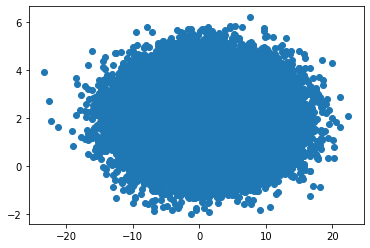

In [8]:
visualize_data(data_1)

In [0]:
data_2 = sample_data_2()

In [10]:
print(f'Data 2 shape is {data_2.shape}')

Data 2 shape is (100000, 2)


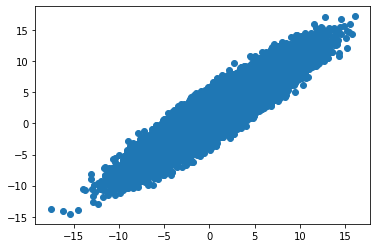

In [11]:
visualize_data(data_2)

In [0]:
np.random.seed(23923)

In [0]:
data_1_train, data_1_val = train_test_split(data_1, train_size=0.8)
data_2_train, data_2_val = train_test_split(data_2, train_size=0.8)

In [14]:
print(f'data_1_val shape is {data_1_val.shape}, data_1_train shape is {data_1_train.shape}')
print(f'data_2_val shape is {data_2_val.shape}, data_2_train shape is {data_2_train.shape}')

data_1_val shape is (20000, 2), data_1_train shape is (80000, 2)
data_2_val shape is (20000, 2), data_2_train shape is (80000, 2)


In [0]:
data_1_val = torch.from_numpy(data_1_val).float()
data_2_val = torch.from_numpy(data_2_val).float()
data_1_train = torch.from_numpy(data_1_train).float()
data_2_train = torch.from_numpy(data_2_train).float()

In [0]:
batch_size = 5000

data_1_train_batches = torch.utils.data.DataLoader(data_1_train, batch_size=batch_size)
data_2_train_batches = torch.utils.data.DataLoader(data_2_train, batch_size=batch_size)
data_1_val_batches = torch.utils.data.DataLoader(data_1_val, batch_size=batch_size)
data_2_val_batches = torch.utils.data.DataLoader(data_2_val, batch_size=batch_size)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def get_loss(x, output):
  mu, sigma, mu_x, sigma_x = output
  pl = -0.5 * (torch.log(np.pi * 2 * sigma_x) + torch.pow(x - mu_x, 2) / sigma_x)
  pl = -pl.sum(dim=1)
  pl = pl.mean()
  kl = -0.5 * (1. + torch.log(sigma) - mu**2 - sigma)
  kl = kl.sum(dim=1)
  kl = kl.mean()
  return pl, kl

In [0]:
def plot_losses(train_losses, val_losses, title='Losses'):
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  epoches = range(0, len(train_losses))
  plt.plot(epoches, train_losses, label='train loss')
  plt.plot(epoches, val_losses, label='val loss')
  plt.legend()
  plt.show()

In [0]:
def train(model, train_batches, val_batches, lossf=get_loss, epoches_number=6, lr=1e-2, batch_size=100, epoch_print=4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  val_losses = []

  for epoch in range(epoches_number):
    losses = []
    for batch in train_batches:
      optimizer.zero_grad()
      output = model(batch)
      pl, kl = lossf(batch, output)
      # print(pl, kl)
      loss = pl + kl
      loss.backward()
      optimizer.step()
      losses.append([pl.detach().numpy(), kl.detach().numpy()])
    losses = np.array(losses)
    train_losses.append([losses[:,0].mean(), losses[:,1].mean()])

    with torch.no_grad():
      losses = []
      for batch in val_batches:
        output = model(batch)
        pl, kl = lossf(batch, output)
        loss = pl + kl
        losses.append((pl.detach().numpy(), kl.detach().numpy()))
    losses = np.array(losses)
    val_losses.append([losses[:,0].mean(), losses[:,1].mean()])
    
    if epoch % epoch_print == 0 or epoch == epoches_number - 1:
      train_loss = np.mean(train_losses[-1])
      val_loss = np.mean(val_losses[-1])
      print(f'Epoch: {epoch}, train loss: {train_loss}, val loss: {val_loss}')
    
  train_losses = np.array(train_losses)
  val_losses = np.array(val_losses)

  plot_losses(train_losses[:,0], val_losses[:, 0], title='Prob losses')
  plot_losses(train_losses[:,1], val_losses[:, 1], title='KL losses')
  plot_losses(train_losses.sum(axis=1), val_losses.sum(axis=1), title='Losses')

**First model**

**First dataset**

In [0]:
class VAE1(nn.Module):
  def __init__(self, size=128):
    super(VAE1, self).__init__()

    self.size = size

    self.encoder = nn.Sequential(
        nn.Linear(2, size),
        nn.ReLU(),
        nn.Linear(size, size),
        nn.ReLU(),
        nn.Linear(size, 4)
    )

    self.decoder = nn.Sequential(
        nn.Linear(2, size),
        nn.ReLU(),
        nn.Linear(size, size),
        nn.ReLU(),
        nn.Linear(size, 4)
    )

  def encode(self, x):
    x = self.encoder(x)
    mu, sigma = x[:, :2], torch.exp(x[:, 2:])
    return mu, sigma

  def decode(self, x):
    x = self.decoder(x)
    mu, sigma = x[:, :2], torch.exp(x[:, 2:])
    return mu, sigma

  def sample(self, mu, sigma):
    return mu + torch.randn(size=mu.shape) * torch.sqrt(sigma)

  def forward(self, x):
    mu, sigma = self.encode(x)
    z = self.sample(mu, sigma)
    mu_x, sigma_x = self.decode(z)
    return mu, sigma, mu_x, sigma_x

Epoch: 0, train loss: 3.2007298469543457, val loss: 2.347602367401123
Epoch: 10, train loss: 2.2221555709838867, val loss: 2.2260501384735107
Epoch: 20, train loss: 2.221771240234375, val loss: 2.225803852081299
Epoch: 30, train loss: 2.2219700813293457, val loss: 2.2259764671325684
Epoch: 40, train loss: 2.2217652797698975, val loss: 2.2261760234832764
Epoch: 50, train loss: 2.221613883972168, val loss: 2.2253966331481934
Epoch: 60, train loss: 2.2218055725097656, val loss: 2.2254369258880615
Epoch: 70, train loss: 2.2220025062561035, val loss: 2.2253165245056152
Epoch: 80, train loss: 2.222047805786133, val loss: 2.225215196609497
Epoch: 90, train loss: 2.221953868865967, val loss: 2.2251205444335938
Epoch: 99, train loss: 2.2221148014068604, val loss: 2.225149393081665


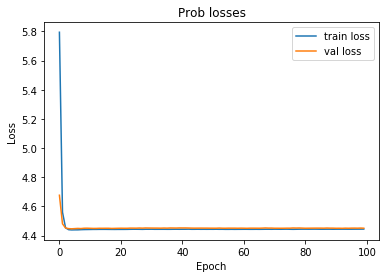

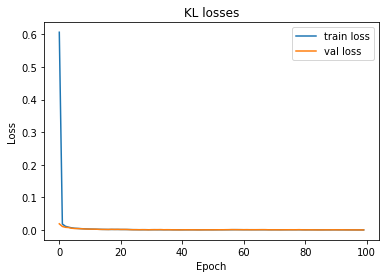

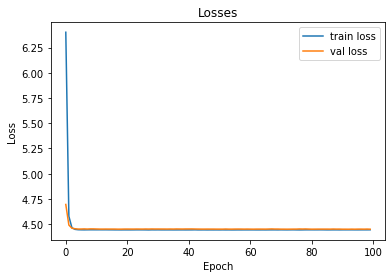

In [74]:
model = VAE1()
train(model, data_1_train_batches, data_1_val_batches, epoches_number=100, epoch_print=10)

In [0]:
def plot_samples(model, samples_number=100000):
  with torch.no_grad():
    z = torch.randn(size=(samples_number, 2))
    mu, sigma = model.decode(z)
    print(sigma.shape)
    x = model.sample(mu, sigma).detach().numpy()
    mu = mu.detach().numpy()
    sigma = sigma.detach().numpy()
    plt.scatter(x[:, 0], x[:, 1])
    plt.scatter(mu[:, 0], mu[:, 1])
    plt.show()

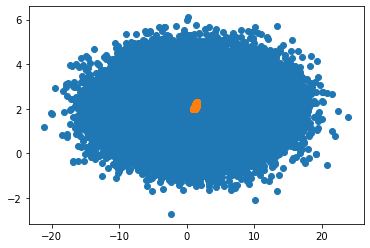

In [78]:
plot_samples(model)

Second dataset

Epoch: 0, train loss: 3.5341885089874268, val loss: 2.7502694129943848
Epoch: 10, train loss: 2.232463836669922, val loss: 2.2300078868865967
Epoch: 20, train loss: 2.2243833541870117, val loss: 2.2303621768951416
Epoch: 30, train loss: 2.227376699447632, val loss: 2.223130464553833
Epoch: 40, train loss: 2.225311756134033, val loss: 2.229423999786377
Epoch: 50, train loss: 2.227205514907837, val loss: 2.2211575508117676
Epoch: 60, train loss: 2.2246017456054688, val loss: 2.2292075157165527
Epoch: 70, train loss: 2.2235212326049805, val loss: 2.2235538959503174
Epoch: 80, train loss: 2.228200674057007, val loss: 2.2226359844207764
Epoch: 90, train loss: 2.2249598503112793, val loss: 2.2247462272644043
Epoch: 99, train loss: 2.2251386642456055, val loss: 2.224368095397949


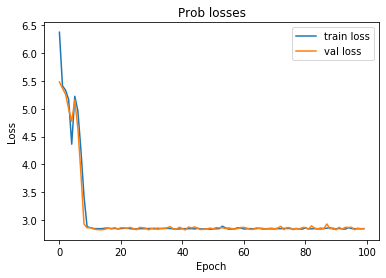

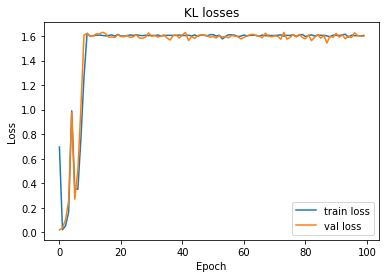

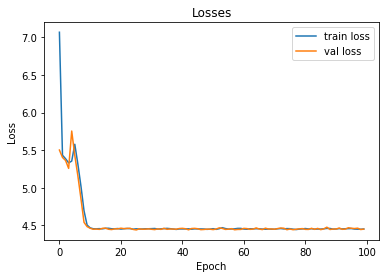

In [79]:
model = VAE1()
train(model, data_2_train_batches, data_2_val_batches, epoches_number=100, epoch_print=10)

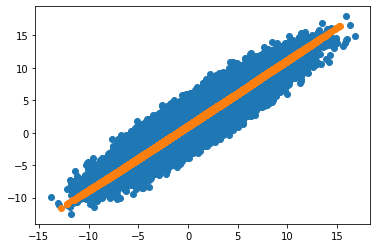

In [80]:
plot_samples(model)

**Second model**

In [0]:
class VAE2(nn.Module):
  def __init__(self, size=128):
    super(VAE2, self).__init__()

    self.size = size

    self.encoder = nn.Sequential(
        nn.Linear(2, size),
        nn.ReLU(),
        nn.Linear(size, size),
        nn.ReLU(),
        nn.Linear(size, 3)
    )

    self.decoder = nn.Sequential(
        nn.Linear(2, size),
        nn.ReLU(),
        nn.Linear(size, size),
        nn.ReLU(),
        nn.Linear(size, 3)
    )

  def encode(self, x):
    x = self.encoder(x)
    mu, sigma = x[:, :2], torch.exp(x[:, 2:] * torch.tensor([[1, 1]]))
    return mu, sigma

  def decode(self, x):
    x = self.decoder(x)
    mu, sigma = x[:, :2], torch.exp(x[:, 2:] * torch.tensor([[1, 1]]))
    return mu, sigma

  def sample(self, mu, sigma):
    return mu + torch.randn(size=mu.shape) * torch.sqrt(sigma)

  def forward(self, x):
    mu, sigma = self.encode(x)
    z = self.sample(mu, sigma)
    mu_x, sigma_x = self.decode(z)
    return mu, sigma, mu_x, sigma_x

**First dataset**

Epoch: 0, train loss: 3.6864259243011475, val loss: 2.7649354934692383
Epoch: 10, train loss: 2.39198637008667, val loss: 2.379974842071533
Epoch: 20, train loss: 2.356869697570801, val loss: 2.3746683597564697
Epoch: 30, train loss: 2.358640432357788, val loss: 2.3621881008148193
Epoch: 40, train loss: 2.3518407344818115, val loss: 2.3573527336120605
Epoch: 50, train loss: 2.3489198684692383, val loss: 2.3550801277160645
Epoch: 60, train loss: 2.347032070159912, val loss: 2.366743564605713
Epoch: 70, train loss: 2.354705810546875, val loss: 2.355687379837036
Epoch: 80, train loss: 2.357527256011963, val loss: 2.3615946769714355
Epoch: 90, train loss: 2.355095863342285, val loss: 2.358098030090332
Epoch: 99, train loss: 2.3456366062164307, val loss: 2.3544747829437256


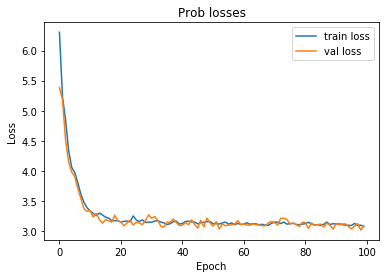

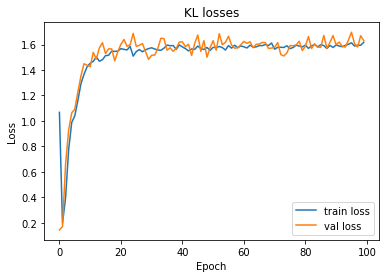

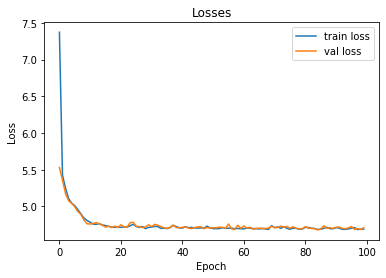

In [101]:
model = VAE2()
train(model, data_1_train_batches, data_1_val_batches, epoches_number=100, epoch_print=10)

torch.Size([100000, 2])


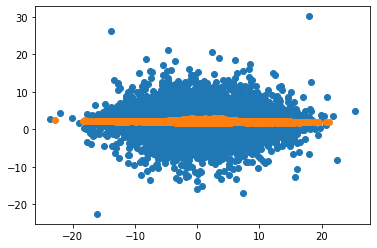

In [102]:
plot_samples(model)

**Second dataset**

Epoch: 0, train loss: 3.7341673374176025, val loss: 2.8510727882385254
Epoch: 10, train loss: 2.430899143218994, val loss: 2.416403293609619
Epoch: 20, train loss: 2.359863042831421, val loss: 2.3599114418029785
Epoch: 30, train loss: 2.351581335067749, val loss: 2.3559370040893555
Epoch: 40, train loss: 2.3526806831359863, val loss: 2.351030111312866
Epoch: 50, train loss: 2.3527607917785645, val loss: 2.348430633544922
Epoch: 60, train loss: 2.3503170013427734, val loss: 2.3473432064056396
Epoch: 70, train loss: 2.3470988273620605, val loss: 2.3440537452697754
Epoch: 80, train loss: 2.3470113277435303, val loss: 2.3433997631073
Epoch: 90, train loss: 2.357168674468994, val loss: 2.3699822425842285
Epoch: 99, train loss: 2.3442437648773193, val loss: 2.365119457244873


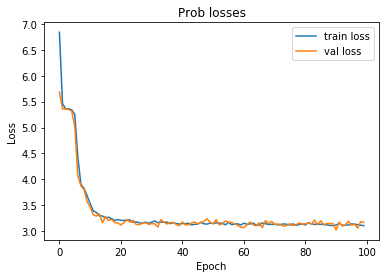

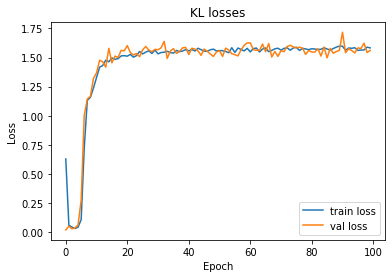

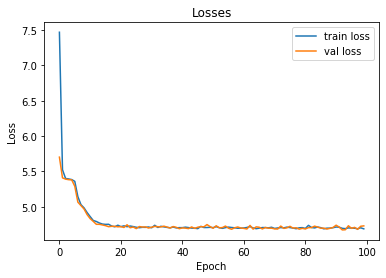

In [103]:
model = VAE2()
train(model, data_2_train_batches, data_2_val_batches, epoches_number=100, epoch_print=10)

torch.Size([100000, 2])


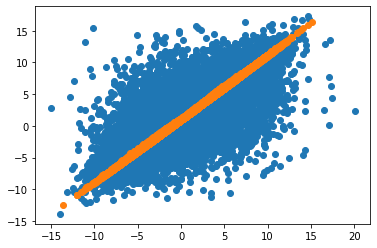

In [104]:
plot_samples(model)

### **Part B**

In [0]:
def sample_data_3():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

In [0]:
x, y = sample_data_3()

In [110]:
print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

x shape is (99999, 2)
y shape is (99999,)


In [0]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8)

In [112]:
print(f'x_val shape is {x_val.shape}, x_train shape is {x_train.shape}')
print(f'y_val shape is {y_val.shape}, y_train shape is {x_train.shape}')

x_val shape is (20000, 2), x_train shape is (79999, 2)
y_val shape is (20000,), y_train shape is (79999, 2)


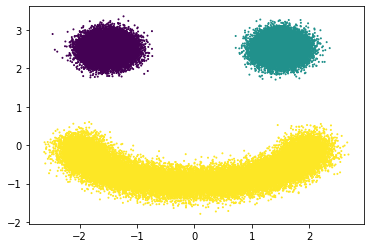

In [130]:
plt.scatter(x[:, 0], x[:, 1], 1, y)
plt.show()

In [0]:
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

In [0]:
batch_size = 5000

x_train_batches = torch.utils.data.DataLoader(x_train, batch_size=batch_size)
y_train_batches = torch.utils.data.DataLoader(y_train, batch_size=batch_size)
x_val_batches = torch.utils.data.DataLoader(x_val, batch_size=batch_size)
y_val_batches = torch.utils.data.DataLoader(y_val, batch_size=batch_size)

In [0]:
class VAE3(nn.Module):
  def __init__(self, size=256):
    super(VAE3, self).__init__()

    self.size = size

    self.encoder = nn.Sequential(
        nn.Linear(2, size),
        nn.ReLU(),
        nn.Linear(size, 4)
    )

    self.decoder = nn.Sequential(
        nn.Linear(2, size),
        nn.ReLU(),
        nn.Linear(size, 4)
    )

  def encode(self, x):
    x = self.encoder(x)
    mu, sigma = x[:, :2], torch.exp(x[:, 2:])
    return mu, sigma

  def decode(self, x):
    x = self.decoder(x)
    mu, sigma = x[:, :2], torch.exp(x[:, 2:])
    return mu, sigma

  def sample(self, mu, sigma):
    return mu + torch.randn(size=mu.shape) * torch.sqrt(sigma)

  def forward(self, x):
    mu, sigma = self.encode(x)
    z = self.sample(mu, sigma)
    mu_x, sigma_x = self.decode(z)
    return mu, sigma, mu_x, sigma_x

Epoch: 0, train loss: 2.2203681468963623, val loss: 1.9586530923843384
Epoch: 10, train loss: 1.2297269105911255, val loss: 1.2003839015960693
Epoch: 20, train loss: 1.1240557432174683, val loss: 1.0677846670150757
Epoch: 30, train loss: 1.0524992942810059, val loss: 1.0131466388702393
Epoch: 40, train loss: 1.0283087491989136, val loss: 1.0062053203582764
Epoch: 50, train loss: 0.9746155738830566, val loss: 0.9850931763648987
Epoch: 60, train loss: 0.9622575044631958, val loss: 0.9559016227722168
Epoch: 70, train loss: 0.9556246995925903, val loss: 0.9602517485618591
Epoch: 80, train loss: 0.9651999473571777, val loss: 1.0688982009887695
Epoch: 90, train loss: 0.9355891942977905, val loss: 0.9289549589157104
Epoch: 100, train loss: 0.9488101601600647, val loss: 0.9947124719619751
Epoch: 110, train loss: 0.9284121990203857, val loss: 0.9434736967086792
Epoch: 120, train loss: 0.9394586682319641, val loss: 0.9093564748764038
Epoch: 130, train loss: 1.0984783172607422, val loss: 0.968877

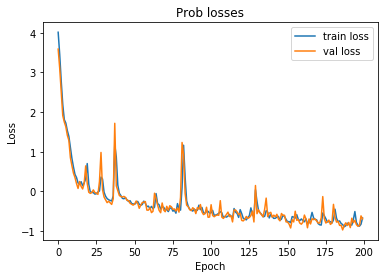

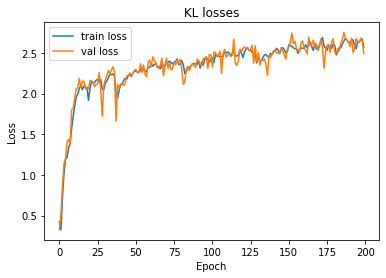

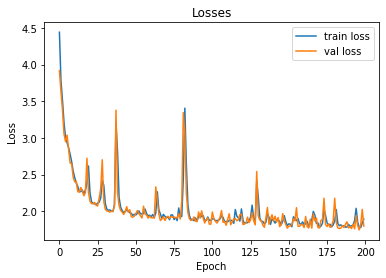

In [141]:
model = VAE3()
train(model, x_train_batches, x_val_batches, epoches_number=200, epoch_print=10)

torch.Size([100000, 2])


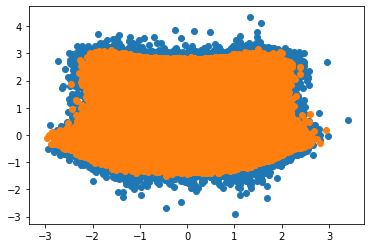

In [142]:
plot_samples(model)

In [0]:
def plot_latent(model, x, y, samples_number=100000):
  with torch.no_grad():
    mu, sigma = model.encode(torch.from_numpy(x).float())
    x = model.sample(mu, sigma).detach().numpy()
    
    plt.scatter(x[:, 0], x[:, 1], 1, y)
    plt.show()

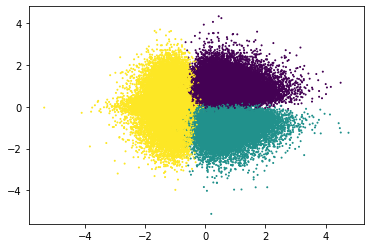

In [144]:
plot_latent(model, x, y)

In [0]:
x_pick = x_val[:100]

In [0]:
def get_p(x, mu, sigma):
    prob = torch.exp(-0.5 * (x - mu) ** 2 / sigma) / torch.sqrt(2 * np.pi * sigma)
    return prob.prod(dim=1)

def get_iwae(model, x):
  with torch.no_grad():
    mu_x, sigma_x = model.encode(x)
    z = model.sample(mu_x, sigma_x)
    mu_z, sigma_z = model.decode(z)
    r = get_p(x, mu_z, sigma_z)
    r *= get_p(z, torch.zeros_like(mu_x), torch.ones_like(sigma_x))
    r /= get_p(z, mu_x, sigma_x)
    return r.mean().log()

In [153]:
print(f'IWAE: {get_iwae(model, x_pick)}')
print(f'ELBO: {get_iwae(model, x_val[:1])}')

IWAE: -1.2766739130020142
ELBO: -1.6394963264465332
